In [3]:
# augmenting the dataset the following data to create super rows
# - last 5 / 10 games PTS, REB, AST, MIN, FGA
# - home game flag
# - back-to-back flag
# - season-level stats (season averages, shooting %, etc.)

import pandas as pd
import numpy as np

# load per game data
games = pd.read_csv("../data/nba_games_with_travel.csv")

# load season data
season = pd.read_csv("../data/nba_player_stats_2016_2024.csv")

# sort data
games["GAME_DATE"] = pd.to_datetime(games["GAME_DATE"])
games = games.sort_values(["PLAYER_ID", "GAME_DATE"])

# get previous season label
def get_prev_season(season_label):
    year1 = int(season_label.split("-")[0])
    prev_year1 = year1 - 1
    prev_year2 = str((prev_year1 + 1) % 100).zfill(2)
    return f"{prev_year1}-{prev_year2}"

games["PREV_SEASON"] = games["SEASON_LABEL"].apply(get_prev_season)

# keep useful season columns
season_cols_useful = [
    "PLAYER_ID", "SEASON",
    "PTS", "REB", "AST", "MIN",
    "FG_PCT", "FG3_PCT", "FT_PCT"
]

# rename to not conflict with per game columns
season_stat = season[season_cols_useful].rename(columns={
    "PTS": "SEASON_PTS",
    "REB": "SEASON_REB",
    "AST": "SEASON_AST",
    "MIN": "SEASON_MIN",
    "FG_PCT": "SEASON_FG_PCT",
    "FG3_PCT": "SEASON_FG3_PCT",
    "FT_PCT": "SEASON_FT_PCT"
})

# merge to super row
df = games.merge(
    season_stat,
    left_on=["PLAYER_ID", "PREV_SEASON"],
    right_on=["PLAYER_ID", "SEASON"],
    how="left"
)
df = df.sort_values(["PLAYER_ID", "GAME_DATE"])

# calculate rolling stats
rolling_stats = ["PTS", "REB", "AST", "MIN", "FGA",
                 "FG_PCT", "FG3_PCT", "FT_PCT"]
for stat in rolling_stats:
    if stat not in df.columns:
        print(f"Warning: '{stat}' not in df.columns, skipping rolling features for it.")
        continue

    df[f"{stat}_LAST5"] = (
        df.groupby("PLAYER_ID")[stat]
          .rolling(5)
          .mean()
          .reset_index(0, drop=True)
    )
    df[f"{stat}_LAST10"] = (
        df.groupby("PLAYER_ID")[stat]
          .rolling(10)
          .mean()
          .reset_index(0, drop=True)
    )

# add home_game columns and b2b columns
df["HOME_GAME"] = df["MATCHUP"].str.contains("vs").astype(int)
df["BACK_TO_BACK"] = (df["DAYS_REST"] == 1).astype(int)

# delete NaN
df = df.fillna(0)

# save csv
df.to_csv("../data/final_dataset.csv", index=False)
print("final_dataset.csv created")
print("Shape:", df.shape)

final_dataset.csv created
Shape: (202129, 62)


In [4]:
from sklearn.model_selection import train_test_split

#load dataset
df = pd.read_csv("../data/final_dataset.csv")

features = [
    # last 5 and las 10
    "PTS_LAST5", "PTS_LAST10",
    "REB_LAST5", "REB_LAST10",
    "AST_LAST5", "AST_LAST10",
    "MIN_LAST5", "MIN_LAST10",
    "FGA_LAST5", "FGA_LAST10",
    "FG_PCT_LAST5", "FG_PCT_LAST10",
    "FG3_PCT_LAST5", "FG3_PCT_LAST10",
    "FT_PCT_LAST5", "FT_PCT_LAST10",

    # travel
    "DISTANCE_TRAVELED_KM",
    "DAYS_REST",
    "BACK_TO_BACK",
    "HOME_GAME",

    # season features
    "SEASON_PTS", "SEASON_REB", "SEASON_AST",
    "SEASON_MIN", "SEASON_FG_PCT",
    "SEASON_FG3_PCT", "SEASON_FT_PCT"
]


target = "PTS"

#make sure no NaN
df = df.dropna(subset=features + [target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1
)



In [5]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, preds, feature_names):
    
    #metrics
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    print("\nMODEL RESULTS")
    print(f"RMSE: {rmse:.3f}")
    print(f"R² Score: {r2:.3f}")

    # Convert to arrays for plotting
    y_true = np.array(y_test)
    y_pred = np.array(preds)


    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=8, alpha=0.25)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color="red", lw=2)
    plt.title("Predicted vs Actual Points")
    plt.xlabel("Actual Points")
    plt.ylabel("Predicted Points")
    plt.grid(alpha=0.3)
    plt.show()


    errors = y_true - y_pred

    plt.figure(figsize=(7,4))
    plt.hist(errors, bins=40, color="skyblue", alpha=0.85)
    plt.title("Prediction Residuals (Actual − Predicted)")
    plt.xlabel("Error (Points)")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

    return rmse, r2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.7min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s



MODEL RESULTS
RMSE: 5.140
R² Score: 0.642


[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.1s finished


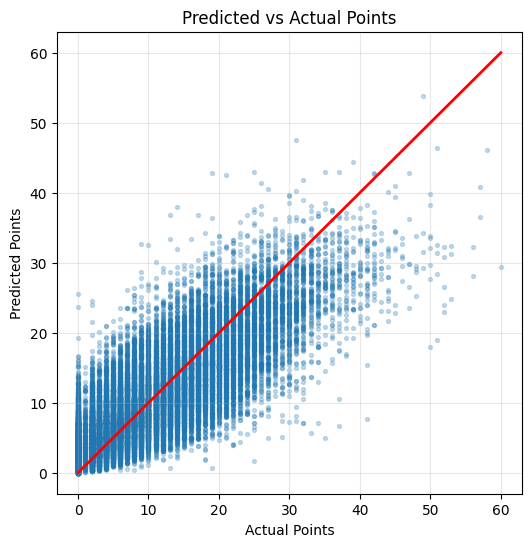

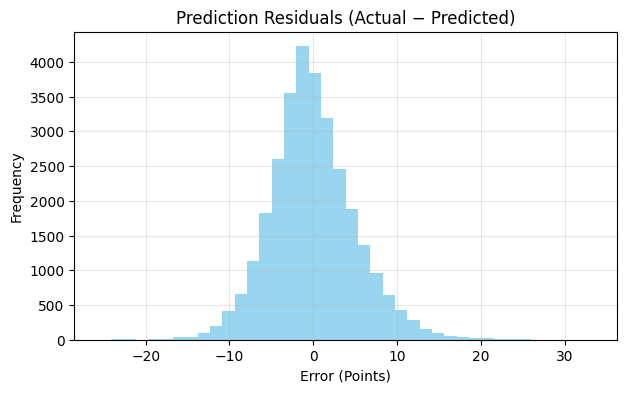

In [6]:
from sklearn.ensemble import RandomForestRegressor
# random forest method in the hw

rf_model = RandomForestRegressor(
    # number of trees
    n_estimators = 400,
    # tree max depth
    max_depth = 20,
    # n samples before splitting
    min_samples_split = 4,
    random_state = 1,
    verbose = 1,
    n_jobs=-1 # use all CPU for faster computation
)

rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

# print rmse, r2, and draw graph
rf_rmse, rf_r2 = evaluate_model(
    model = rf_model,
    X_test = X_test,
    y_test = y_test,
    preds = preds,
    feature_names = features
)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1          68.5238           4.4955            2.61m
         2          64.8294           5.3996            2.64m
         3          61.1686           3.5982            2.62m
         4          57.7256           2.7355            2.61m
         5          54.6786           2.7395            2.61m
         6          52.0806           3.0673            2.60m
         7          49.4857           1.8649            2.57m
         8          47.4277           2.8030            2.56m
         9          45.4986           2.3523            2.55m
        10          43.4949           1.0586            2.55m
        20          32.5734           0.1143            2.45m
        30          28.4508          -0.0317            2.37m
        40          26.9985           0.7283            2.33m
        50          26.3254           0.5859            2.27m
        60          26.1842           0.4727            2.20m
       

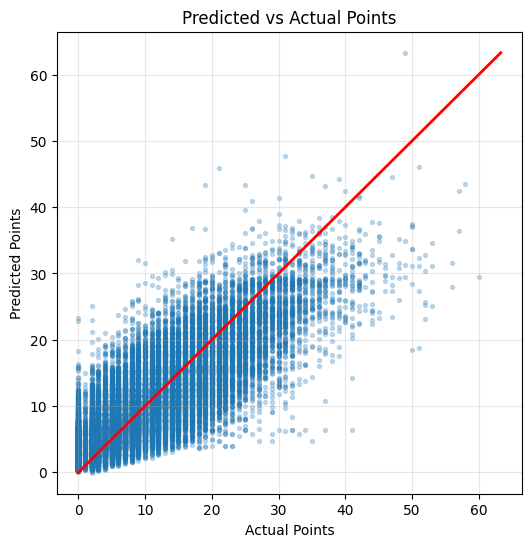

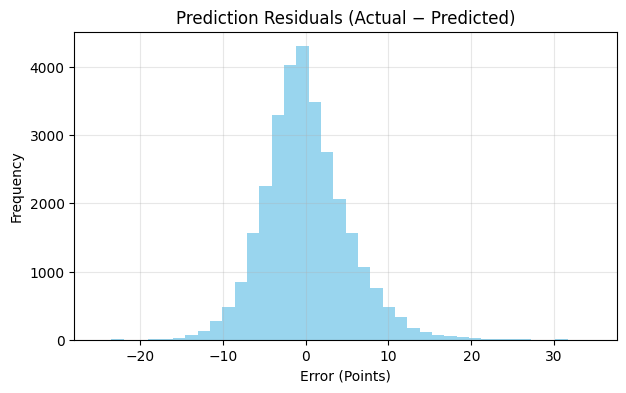

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
# boosting tree method in the hw

gb_model = GradientBoostingRegressor(
    # number of trees
    n_estimators = 400,      
    learning_rate = 0.05,   
    max_depth = 3, 
    # use 80% of data per stage
    subsample = 0.8,        
    random_state = 1,
    verbose = 1
)

gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

# print rmse, r2, and draw graph
gb_rmse, gb_r2 = evaluate_model(
    model = gb_model,
    X_test = X_test,
    y_test = y_test,
    preds = gb_preds,
    feature_names = features
)

Binning 0.033 GB of training data: 

c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系統找不到指定的檔案。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\neolu\anaconda3\envs\final441\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\neolu\anaconda3\envs\final441\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\neolu\anaconda3\envs\final441\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


0.287 s
Binning 0.004 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/300] 1 tree, 31 leaves, max depth = 6, train loss: 34.23663, val loss: 34.61656, in 0.022s
[2/300] 1 tree, 31 leaves, max depth = 6, train loss: 32.16086, val loss: 32.54345, in 0.019s
[3/300] 1 tree, 31 leaves, max depth = 6, train loss: 30.28701, val loss: 30.67138, in 0.018s
[4/300] 1 tree, 31 leaves, max depth = 6, train loss: 28.59566, val loss: 28.97991, in 0.019s
[5/300] 1 tree, 31 leaves, max depth = 6, train loss: 27.06862, val loss: 27.45185, in 0.015s
[6/300] 1 tree, 31 leaves, max depth = 6, train loss: 25.69029, val loss: 26.07288, in 0.012s
[7/300] 1 tree, 31 leaves, max depth = 6, train loss: 24.44551, val loss: 24.82597, in 0.012s
[8/300] 1 tree, 31 leaves, max depth = 6, train loss: 23.32188, val loss: 23.69951, in 0.012s
[9/300] 1 tree, 31 leaves, max depth = 6, train loss: 22.30719, val loss: 22.68046, in 0.012s
[10/300] 1 tree, 31 leaves, max depth = 6, train loss: 21.39112, val

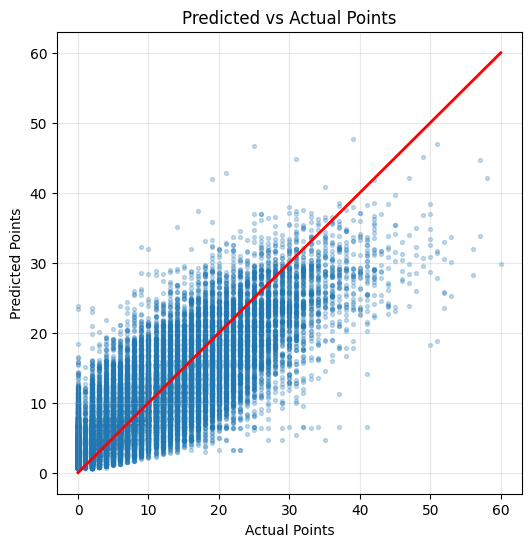

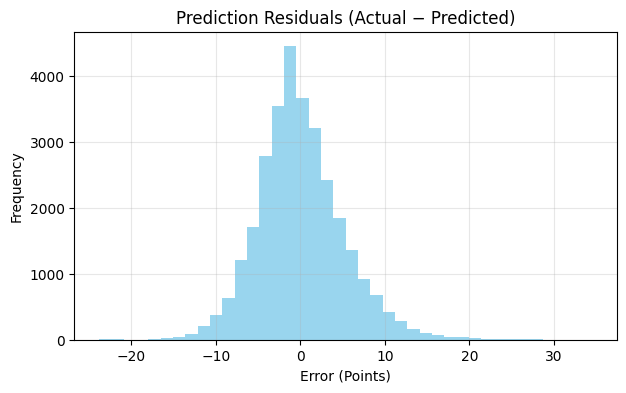

In [8]:
from sklearn.ensemble import HistGradientBoostingRegressor
# another regressor from ensemble

hgb_model = HistGradientBoostingRegressor(
    learning_rate = 0.05,
    max_depth = 8,
    max_iter = 300,      
    random_state = 1,
    verbose = 1
)

hgb_model.fit(X_train, y_train)
hgb_preds = hgb_model.predict(X_test)

hgb_rmse, hgb_r2 = evaluate_model(
    model = hgb_model,
    X_test = X_test,
    y_test = y_test,
    preds = hgb_preds,
    feature_names = features
)




MODEL RESULTS
RMSE: 5.277
R² Score: 0.623


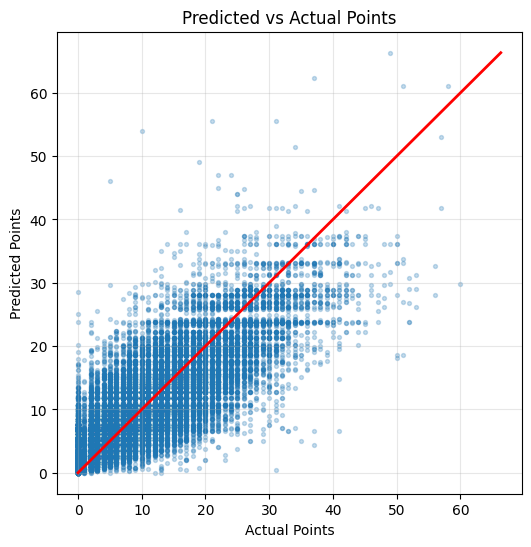

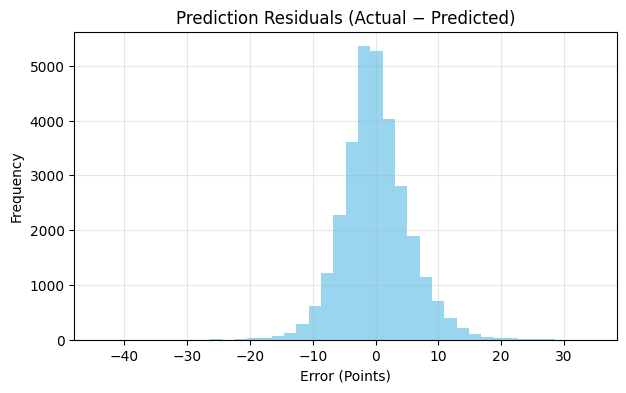

In [9]:
from sklearn.tree import DecisionTreeRegressor
# decision tree from hw

dt_model = DecisionTreeRegressor(
    max_depth = 12,
    min_samples_split = 10,
    random_state = 1
)

dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

dt_rmse = mean_squared_error(y_test, dt_preds, squared=False)
dt_r2 = r2_score(y_test, dt_preds)


dt_rmse, dt_r2 = evaluate_model(
    model = dt_model,
    X_test = X_test,
    y_test = y_test,
    preds = dt_preds,
    feature_names = features
)


Training ARIMA model for Player ID: 1627741
Train samples: 537, Test samples: 95

ARIMA RESULTS for Player 1627741
RMSE: 7.149


c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

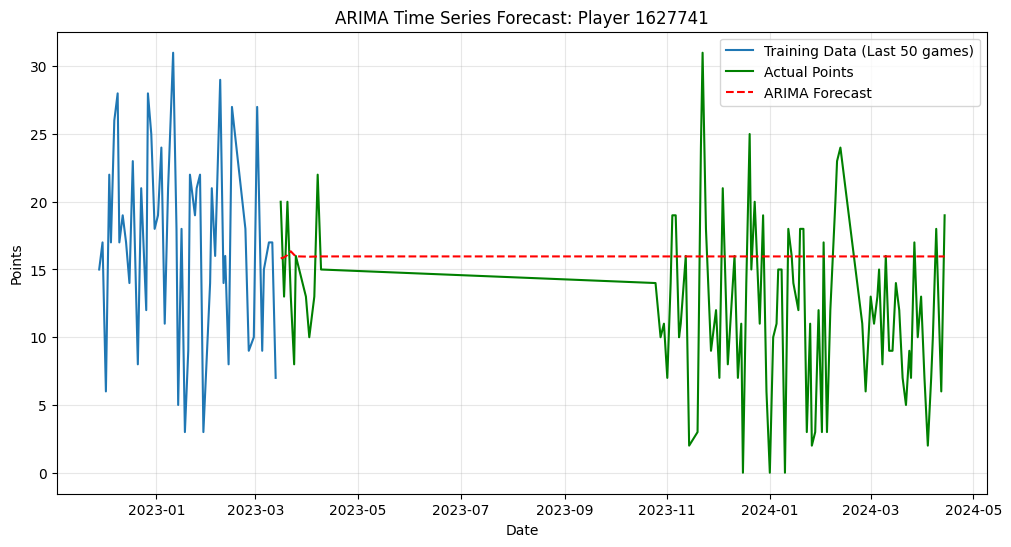

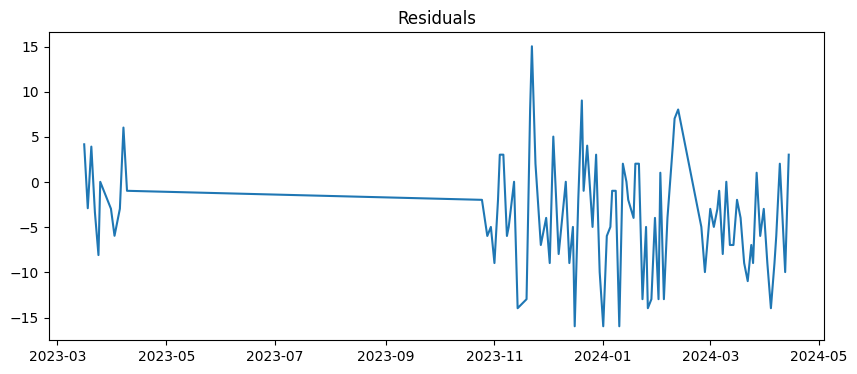

In [12]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 1. PREPARE DATA FOR TIME SERIES
# ARIMA requires a single sequence of data sorted by time.
# We cannot feed it the whole mixed dataset. Let's pick the player with the most games.
most_frequent_player_id = df['PLAYER_ID'].value_counts().idxmax()
player_name_guess = "Player " + str(most_frequent_player_id) # We don't have the name column, just ID

print(f"Training ARIMA model for Player ID: {most_frequent_player_id}")

# Filter for this specific player and sort by date
player_df = df[df['PLAYER_ID'] == most_frequent_player_id].copy()
player_df['GAME_DATE'] = pd.to_datetime(player_df['GAME_DATE'])
player_df = player_df.sort_values('GAME_DATE')

# Set the date as index and pick the target series (Points)
# ARIMA only looks at the target variable history, it ignores other features like 'HOME_GAME'
time_series = player_df.set_index('GAME_DATE')['PTS']

# 2. SPLIT TRAIN AND TEST (Chronological Split)
# We take the last 15% of games as the test set
split_index = int(len(time_series) * 0.85)
train_pts = time_series.iloc[:split_index]
test_pts = time_series.iloc[split_index:]

print(f"Train samples: {len(train_pts)}, Test samples: {len(test_pts)}")

# 3. DEFINE AND FIT ARIMA MODEL
# Order (p,d,q) parameters:
# p=5: Look at last 5 games (AutoRegressive part)
# d=1: Difference the data once to make it stationary (Integrated part)
# q=1: Moving Average part
# You can tweak these numbers or use a library like 'pmdarima' to find the best ones automatically.
arima_model = ARIMA(train_pts, order=(5, 1, 1)) 
arima_result = arima_model.fit()

# 4. FORECAST
# Predict the points for the test period
start_idx = len(train_pts)
end_idx = len(train_pts) + len(test_pts) - 1
arima_preds = arima_result.predict(start=start_idx, end=end_idx, typ='levels')

# Align the index for plotting
arima_preds.index = test_pts.index

# 5. EVALUATE
arima_rmse = mean_squared_error(test_pts, arima_preds, squared=False)
print(f"\nARIMA RESULTS for Player {most_frequent_player_id}")
print(f"RMSE: {arima_rmse:.3f}")

# 6. VISUALIZE
plt.figure(figsize=(12, 6))
plt.plot(train_pts.index[-50:], train_pts.iloc[-50:], label='Training Data (Last 50 games)')
plt.plot(test_pts.index, test_pts, label='Actual Points', color='green')
plt.plot(arima_preds.index, arima_preds, label='ARIMA Forecast', color='red', linestyle='--')
plt.title(f"ARIMA Time Series Forecast: Player {most_frequent_player_id}")
plt.xlabel("Date")
plt.ylabel("Points")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Show residuals (errors)
residuals = test_pts - arima_preds
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

Training SARIMA model for Player ID: 1627741
Fitting SARIMA model... (this may take a moment)

SARIMA RESULTS for Player 1627741
RMSE: 7.177


c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported

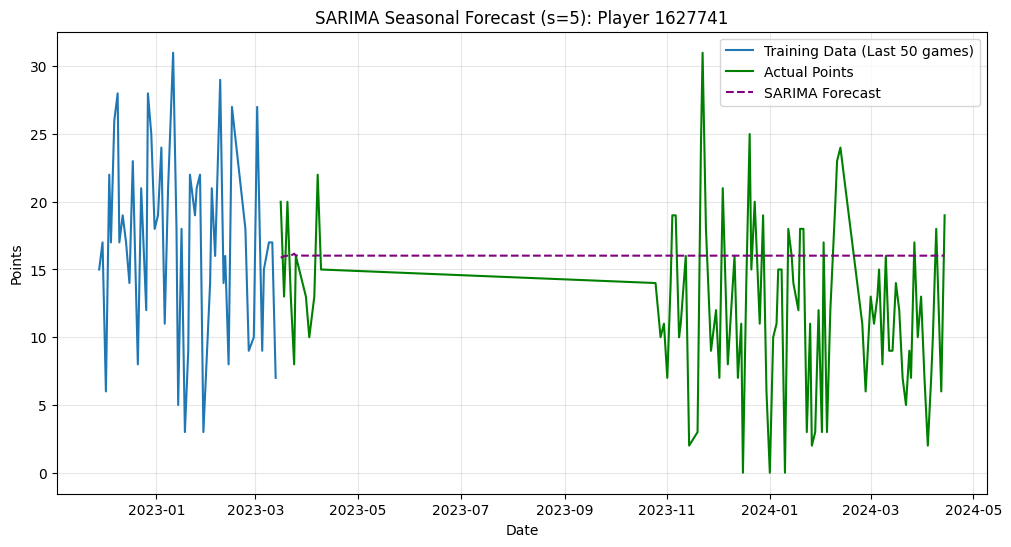

In [14]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pandas as pd

# 1. PREPARE DATA (Same as before)
if 'most_frequent_player_id' not in locals():
    most_frequent_player_id = df['PLAYER_ID'].value_counts().idxmax()

print(f"Training SARIMA model for Player ID: {most_frequent_player_id}")

player_df = df[df['PLAYER_ID'] == most_frequent_player_id].copy()
player_df['GAME_DATE'] = pd.to_datetime(player_df['GAME_DATE'])
player_df = player_df.sort_values('GAME_DATE')

# Set date index and pick target
time_series = player_df.set_index('GAME_DATE')['PTS']

# 2. SPLIT TRAIN AND TEST
split_index = int(len(time_series) * 0.85)
train_pts = time_series.iloc[:split_index]
test_pts = time_series.iloc[split_index:]

# 3. DEFINE SARIMA MODEL
# UPDATED: Changed p from 5 to 2 to avoid conflict with s=5
sarima_model = SARIMAX(train_pts, 
                       order=(2, 1, 1),              # Reduced p to 2
                       seasonal_order=(1, 0, 1, 5),  # Seasonality stays 5
                       enforce_stationarity=False,
                       enforce_invertibility=False)

print("Fitting SARIMA model... (this may take a moment)")
sarima_result = sarima_model.fit(disp=False)

# 4. FORECAST
start_idx = len(train_pts)
end_idx = len(train_pts) + len(test_pts) - 1
sarima_preds = sarima_result.predict(start=start_idx, end=end_idx, typ='levels')
sarima_preds.index = test_pts.index

# 5. EVALUATE
sarima_rmse = mean_squared_error(test_pts, sarima_preds, squared=False)
print(f"\nSARIMA RESULTS for Player {most_frequent_player_id}")
print(f"RMSE: {sarima_rmse:.3f}")

# 6. VISUALIZE
plt.figure(figsize=(12, 6))
plt.plot(train_pts.index[-50:], train_pts.iloc[-50:], label='Training Data (Last 50 games)')
plt.plot(test_pts.index, test_pts, label='Actual Points', color='green')
plt.plot(sarima_preds.index, sarima_preds, label='SARIMA Forecast', color='purple', linestyle='--')
plt.title(f"SARIMA Seasonal Forecast (s=5): Player {most_frequent_player_id}")
plt.xlabel("Date")
plt.ylabel("Points")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()